In [ ]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=5d9163f972ae29ff10944cc200bc63f20383897e437a7a963715d0b9cebbf9e2
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [33]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from google.colab import drive
from fpdf import FPDF
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score


In [ ]:
# Mount Google Drive to save outputs
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load datasets (adjust file names as needed)
customers = pd.read_csv('/content/drive/MyDrive/Customers.csv')  # Replace with your actual filename
transactions = pd.read_csv('/content/drive/MyDrive/Transactions.csv')  # Replace with your actual filename
products = pd.read_csv('/content/drive/MyDrive/Products.csv')  # Replace with your actual filename

In [ ]:
# Reuse feature creation function from the lookalike model
def create_customer_features(customers_df, transactions_df, products_df):
    customer_stats = transactions_df.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean', 'std'],
        'Quantity': ['sum', 'mean', 'std'],
        'TransactionID': 'count'
    }).fillna(0)
    customer_stats.columns = ['_'.join(col).strip() for col in customer_stats.columns.values]
    transaction_products = transactions_df.merge(products_df, on='ProductID')
    category_pivot = pd.pivot_table(
        transaction_products,
        values='TotalValue',
        index='CustomerID',
        columns='Category',
        aggfunc='sum',
        fill_value=0
    )
    category_pivot = category_pivot.div(category_pivot.sum(axis=1), axis=0)
    customer_features = customer_stats.join(category_pivot)
    region_dummies = pd.get_dummies(customers_df.set_index('CustomerID')['Region'], prefix='region')
    customer_features = customer_features.join(region_dummies)
    return customer_features

In [ ]:
# Generate feature matrix
features = create_customer_features(customers, transactions, products)

In [ ]:
# Scale features
scaler = StandardScaler()
scaled_features = pd.DataFrame(
    scaler.fit_transform(features),
    index=features.index,
    columns=features.columns
)

In [44]:
def evaluate_clusters(scaled_features, max_clusters=10):
    metrics = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(scaled_features)
        db_index = davies_bouldin_score(scaled_features, labels)
        silhouette = silhouette_score(scaled_features, labels)
        ch_index = calinski_harabasz_score(scaled_features, labels)
        metrics.append({
            'n_clusters': n_clusters,
            'db_index': db_index,
            'silhouette': silhouette,
            'ch_index': ch_index
        })
    return pd.DataFrame(metrics)

In [45]:
# Evaluate clustering metrics
cluster_metrics = evaluate_clusters(scaled_features)

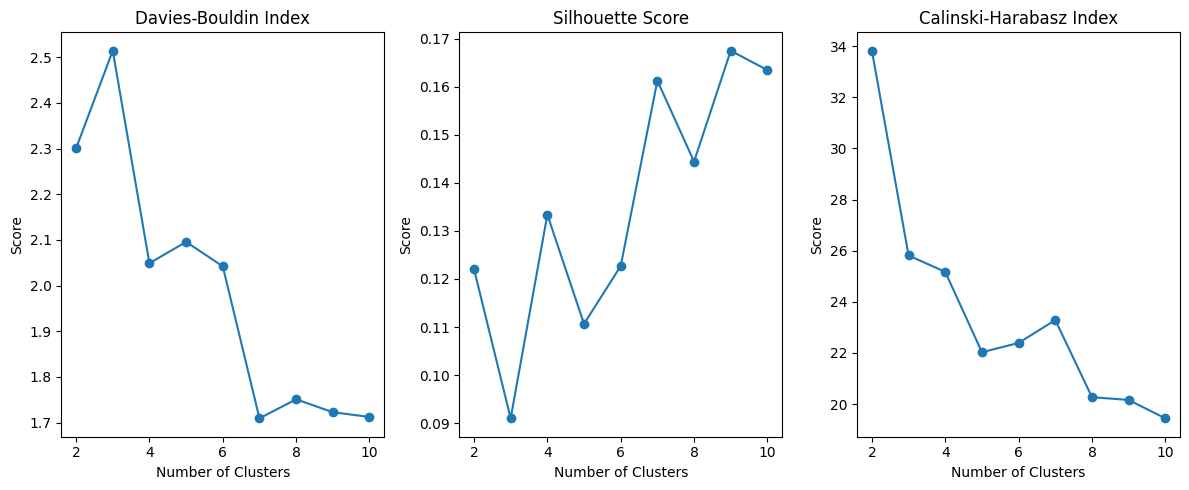

In [46]:
# Plot evaluation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(cluster_metrics['n_clusters'], cluster_metrics['db_index'], marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 3, 2)
plt.plot(cluster_metrics['n_clusters'], cluster_metrics['silhouette'], marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 3, 3)
plt.plot(cluster_metrics['n_clusters'], cluster_metrics['ch_index'], marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

In [47]:
# Choose optimal number of clusters
optimal_clusters = cluster_metrics.loc[cluster_metrics['db_index'].idxmin(), 'n_clusters']

In [48]:
# Perform final clustering
kmeans = KMeans(n_clusters=int(optimal_clusters), random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

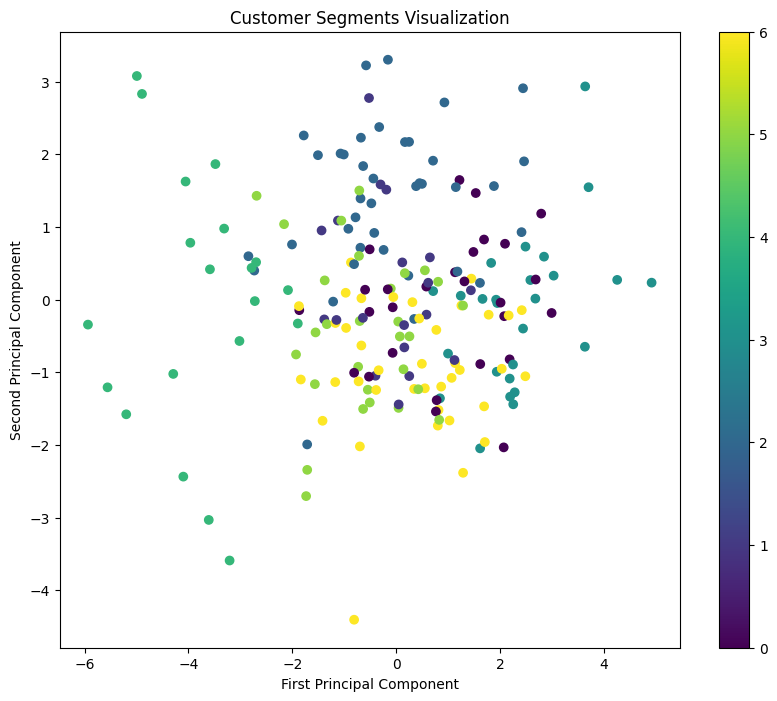

In [ ]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1],
                     c=cluster_labels, cmap='viridis')
plt.title('Customer Segments Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()


In [49]:
# Analyze cluster characteristics
features['Cluster'] = cluster_labels
cluster_profiles = features.groupby('Cluster').mean()



In [ ]:
# Create clustering report
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)
pdf.cell(200, 10, txt="Customer Segmentation Report", ln=1, align='C')

In [ ]:
# Add clustering metrics
pdf.cell(200, 10, txt=f"Number of Clusters: {optimal_clusters}", ln=1, align='L')
pdf.cell(200, 10, txt=f"Davies-Bouldin Index: {davies_bouldin_score(scaled_features, cluster_labels):.3f}", ln=1, align='L')
pdf.cell(200, 10, txt="Summary of Clustering Results:", ln=1, align='L')


In [50]:
# Add cluster profiles (summary of each cluster's mean features)
for cluster_num, profile in cluster_profiles.iterrows():
    pdf.cell(200, 10, txt=f"Cluster {cluster_num}:", ln=1, align='L')
    for feature, value in profile.items():
        pdf.cell(200, 10, txt=f"  {feature}: {value:.3f}", ln=1, align='L')


In [51]:
# Save the report
report_path = '/content/drive/MyDrive/Clustering_Report.pdf'
pdf.output(report_path)

''

In [ ]:
# Save cluster assignments with detailed information (CustomerID and Cluster)
cluster_assignments = pd.DataFrame({
    'CustomerID': features.index,
    'Cluster': cluster_labels
})

# Include customer-specific data (optional, to enrich the CSV with other columns)
cluster_assignments_full = pd.concat([customers.set_index('CustomerID'), cluster_assignments], axis=1)

# Save the detailed cluster assignments to CSV
cluster_assignments_path = '/content/drive/MyDrive/Cluster_Assignments.csv'
cluster_assignments_full.to_csv(cluster_assignments_path, index=False)

print(f"Clustering report saved to: {report_path}")
print(f"Cluster assignments saved to: {cluster_assignments_path}")


Clustering report saved to: /content/drive/MyDrive/Clustering_Report.pdf
Cluster assignments saved to: /content/drive/MyDrive/Cluster_Assignments.csv
